# Model-free Renewable Scenario Generation Using Generative Adversarial Networks

### Yize Chen, Yishen Wang, Daniel Kirschen and Abosen Zhang

Grossly implemented by Pedro Bittencourt based on Yize Chen's original code on https://github.com/chennnnnyize/

For event-based scenario generation and spatial scenario generation, implement the code with labels or 
reshape the imput samples to spatio-temporal samples respectively.
16 is the maximum value for wind capacity we use. Change to the customized max value for normalized data
import ipdb

#Changes
    Learning rate (increased from 0.0002 to 0.002)
    n_epochs (increased from 60 to 200)
    layer dimensions (to those specified in the paper)
   

In [29]:
import os
import pandas as pd
import numpy as np
from model_v2 import *
from util import *
from load import load_wind, load_solar_data, load_wind_data_spatial #Change the data source for other tasks
from numpy import shape
import csv
import matplotlib.pyplot as plt
import gc 

#gc.collect()
#tf.compat.v1.disable_eager_execution()


## Setup variables

In [30]:
n_epochs = 120 #Number of overall training epochs on training data
learning_rate = 0.00005 
batch_size = 32
image_shape = [24,24,1] #The shape for input data
dim_z = 100 #input dimension for samples
dim_W1 = 2048 #first layer neurons
dim_W2 = 1024 #second layer neurons
dim_W3 = 128 #third layer #16 is the maximum value for wind capacity we use. Change to your max value here
dim_channel = 1 #reserved for future use if multi=channels
mu, sigma = 0, 0.1 # input Gaussian
events_num=5 #kind of events

visualize_dim=32
generated_dim=32

## Load datasets

Change here for different datasets

In [31]:
#Comment out corresponding part to reproduce the results for 
#wind_events_generation, solar_events_generation, spatial_generation respectively
trX, trY = load_wind()
#trX, trY=load_solar()
#trX, trY=load_spatial()

print("shape of training samples ", shape(trX))
print("Training data loaded")

(105120, 52)
Maximum value of wind 16.0
(105120, 52)
Shape TrX (9464, 576)
Label shape (9464, 1)
shape of training samples  (9464, 576)
Training data loaded


## Initialize GAN

In [32]:
dcgan_model = GAN(
    dim_y=events_num,#The parameters for controlling the number of events
    batch_size=batch_size,
    image_shape=image_shape,
    dim_z=dim_z,
    dim_W1=dim_W1,
    dim_W2=dim_W2,
    dim_W3=dim_W3
    # Change parameters based on number of events
    #change paprameters here for model revision
    #dim_z: the dimension for input noise
    #W1,W2,W3: the dimension for convolutional layers
        )
print("W_DCGAN model initialized")


W_DCGAN model initialized


In [33]:
#Z_tf,Y_tf: placeholder
#image_tf: image placeholder
#d_cost_tf, g_cost_tf: discriminator and generator cost#16 is the maximum value for wind capacity we use. Change to your max value here
#p_real, p_gen: the output of discriminator to judge real/generated
Z_tf, Y_tf, image_tf, d_cost_tf, g_cost_tf, p_real, p_gen = dcgan_model.build_model()
sess = tf.compat.v1.InteractiveSession()
saver = tf.compat.v1.train.Saver(max_to_keep=10)

discrim_vars = filter(lambda x: x.name.startswith('discrim'), tf.compat.v1.trainable_variables())
gen_vars = filter(lambda x: x.name.startswith('gen'), tf.compat.v1.trainable_variables())
discrim_vars = [i for i in discrim_vars]
gen_vars = [i for i in gen_vars]

train_op_discrim = (tf.compat.v1.train.RMSPropOptimizer(learning_rate=1e-4).minimize(-d_cost_tf, var_list=discrim_vars))
train_op_gen = (tf.compat.v1.train.RMSPropOptimizer(learning_rate=1e-4).minimize(g_cost_tf, var_list=gen_vars))

Z_tf_sample, Y_tf_sample, image_tf_sample = dcgan_model.samples_generator(batch_size=visualize_dim)
tf.compat.v1.global_variables_initializer().run()

Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
Y_np_sample = OneHot(np.random.randint(events_num, size=[visualize_dim]), n=events_num)
iterations = 0
k = 4 #control the balance of training D and G

gen_loss_all=[]#16 is the maximum value for wind capacity we use. Change to your max value here
P_real=[]
P_fake=[]
P_distri=[]
discrim_loss=[]

Initializing the generator
Input Z shape (32, 100)
Input Y shape (32, 5)
Z shape (32, 105)
h1 shape (32, 2048)
h1 shape (32, 2053)
h2 shape (32, 36864)
h2 shape (32, 6, 6, 1024)
shape of yb new (32, 6, 6, 5)
h2 shape (32, 6, 6, 1029)
h3 shape (32, 12, 12, 128)
h3 shape (32, 12, 12, 133)
Initializing the discriminator
Y shape (32, 5)
image shape (32, 24, 24, 1)
yb shape (32, 1, 1, 5)
X shape (32, 24, 24, 6)
h1 shape (32, 12, 12, 128)
h1 shape (32, 12, 12, 133)
h2 shape (32, 6, 6, 1024)
discri shape (32, 2048)
Initializing the discriminator
Y shape (32, 5)
image shape (32, 24, 24, 1)
yb shape (32, 1, 1, 5)
X shape (32, 24, 24, 6)
h1 shape (32, 12, 12, 128)
h1 shape (32, 12, 12, 133)
h2 shape (32, 6, 6, 1024)
discri shape (32, 2048)


c:\python3.6\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [34]:
#begin training
for epoch in range(n_epochs):
    print("epoch" + str(epoch))
    index = np.arange(len(trY))
    np.random.shuffle(index)
    trX = trX[index]
    trY = trY[index]
    trY2 = OneHot(trY, n=events_num)

    for start, end in zip(
            range(0, len(trY), batch_size),
            range(batch_size, len(trY), batch_size)
            ):

        Xs = trX[start:end].reshape([-1, 24, 24, 1])
        Ys = trY2[start:end]

        #use uniform or Gaussian distribution data to generate adversarial samples
        Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)

        #for each iteration, generate g and d respectively, k=2
        if np.mod( iterations, k) == 0:
            _, gen_loss_val = sess.run(
                    [train_op_gen, g_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf: Xs
                        })
            discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf,p_real,p_gen], feed_dict={Z_tf:Zs, image_tf:Xs, Y_tf:Ys})

            '''print("=========== updating G ==========")
            print("iteration:", iterations)
            print("gen loss:", gen_loss_val)
            print("discrim loss:", discrim_loss_val)'''

        else:
            _, discrim_loss_val = sess.run(
                    [train_op_discrim, d_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf:Xs
                        })

            '''print("=========== updating D ==========")
            print("iteration:", iterations)
            print("gen loss:", gen_loss_val)
            print("discrim loss:", discrim_loss_val)'''

            gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: Xs, Y_tf: Ys})
        P_real.append(p_real_val.mean())
        P_fake.append(p_gen_val.mean())
        '''gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: fake_data, Y_tf: Ys})'''
        discrim_loss.append(discrim_loss_val)


        if np.mod(iterations, 1000) == 0:
            print("iterations ", iterations)
            print("Average P(real)=", p_real_val.mean())
            print("Average P(gen)=", p_gen_val.mean())
            print("Discrim loss:", discrim_loss_val)
            Y_np_sample = OneHot(np.random.randint(5, size=[visualize_dim]), n=events_num)
            Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
            generated_samples = sess.run(
                image_tf_sample,
                feed_dict={
                    Z_tf_sample: Z_np_sample,
                    Y_tf_sample: Y_np_sample
                })
            generated_samples=generated_samples.reshape([-1,576])
            generated_samples = generated_samples * 16 #16 is the maximum value for wind capacity we use. Change to your max value here
            csvfile=open('%s.csv' %iterations, 'w')
            writer=csv.writer(csvfile)
            writer.writerows(generated_samples)

        iterations += 1

epoch0
iterations  0
Average P(real)= 0.33549085
Average P(gen)= 0.33855224
Discrim loss: -200.63086
epoch1
epoch2
epoch3
iterations  1000
Average P(real)= 0.3704462
Average P(gen)= 0.2569719
Discrim loss: 7436.6523
epoch4
epoch5
epoch6
iterations  2000
Average P(real)= 0.3659547
Average P(gen)= 0.26966232
Discrim loss: 6310.617
epoch7
epoch8
epoch9
epoch10
iterations  3000
Average P(real)= 0.3636515
Average P(gen)= 0.29478836
Discrim loss: 4513.0156
epoch11
epoch12
epoch13
iterations  4000
Average P(real)= 0.36795387
Average P(gen)= 0.22895521
Discrim loss: 9109.416
epoch14
epoch15
epoch16
iterations  5000
Average P(real)= 0.32197982
Average P(gen)= 0.28332898
Discrim loss: 2533.0215
epoch17
epoch18
epoch19
epoch20
iterations  6000
Average P(real)= 0.37510633
Average P(gen)= 0.2582574
Discrim loss: 7657.8125
epoch21
epoch22
epoch23
iterations  7000
Average P(real)= 0.3730241
Average P(gen)= 0.3170936
Discrim loss: 3665.461
epoch24
epoch25
epoch26
epoch27
iterations  8000
Average P(rea

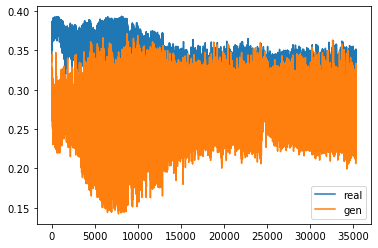

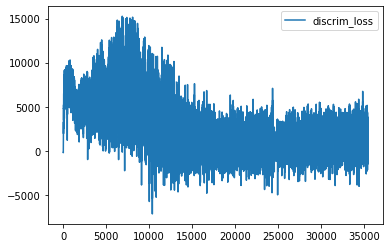

In [35]:
Y_np_sample = OneHot(np.random.randint(5, size=[visualize_dim]), n=events_num) 
Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
generated_samples = sess.run(
    image_tf_sample,
    feed_dict={
        Z_tf_sample: Z_np_sample,
        Y_tf_sample: Y_np_sample
    })
generated_samples=generated_samples.reshape([-1,576])
generated_samples = generated_samples * 16 #16 is the maximum value for wind capacity we use. Change to your max value here
csvfile=open('sample1.csv', 'w')
writer=csv.writer(csvfile)
writer.writerows(generated_samples)
csvfile=open('label1.csv', 'w')
writer=csv.writer(csvfile)
writer.writerows(Y_np_sample)


#plot the loss and P_real as well as P_fake
#print("P_real",P_real)
#print("P_fake",P_fake)

plt.plot(P_real,label="real")
plt.plot(P_fake,label="gen")
plt.legend()
plt.savefig('TrainingEvolutionWindData30012020_200epochs.png', bbox_inches='tight')
plt.show()

plt.plot(discrim_loss,label="discrim_loss")
plt.legend()
plt.savefig('WdistanceWindData30012020_200epochs.png', bbox_inches='tight')
plt.show()



In [ ]:
sess.close()